In [2]:
asset_list = ['AAPL']

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

folder_path = "..\Data Collection & Processing\historical_prices_data" 
forecasts_folder = "..\Data Collection & Processing\stock_forecasts"
performance_folder = "..\Data Collection & Processing\stock_performance"

for asset in asset_list: 
  file_path = os.path.join(folder_path, f"{asset}.csv")
  # Import the top 25 sp500 stocks dataset into a Pandas Dataframe
  df = pd.read_csv(
    file_path,  
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
  )
  


In [4]:
df = df.reset_index()

In [5]:
display(df)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-02-11,18.950357,19.205357,18.910713,19.141430,16.860064,282256800
1,2014-02-12,19.176786,19.270000,19.044287,19.139999,16.858810,308100800
2,2014-02-13,19.094999,19.458929,19.078571,19.443930,17.126516,307398000
3,2014-02-14,19.373928,19.499287,19.328930,19.428213,17.112673,272924400
4,2014-02-18,19.500000,19.685356,19.486071,19.499643,17.175587,260251600
...,...,...,...,...,...,...,...
2512,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.440811,69668800
2513,2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800
2514,2024-02-07,190.639999,191.050003,188.610001,189.410004,189.168625,53439000
2515,2024-02-08,189.389999,189.539993,187.350006,188.320007,188.080017,40962000


In [6]:
df = df.filter(['Date','Close'])
df.head()

,Date,Close
0,2014-02-11,19.141430
1,2014-02-12,19.139999
2,2014-02-13,19.443930
3,2014-02-14,19.428213
4,2014-02-18,19.499643


In [7]:
# To filter negative values
df.index[df['Close'] < 0]

Int64Index([], dtype='int64')

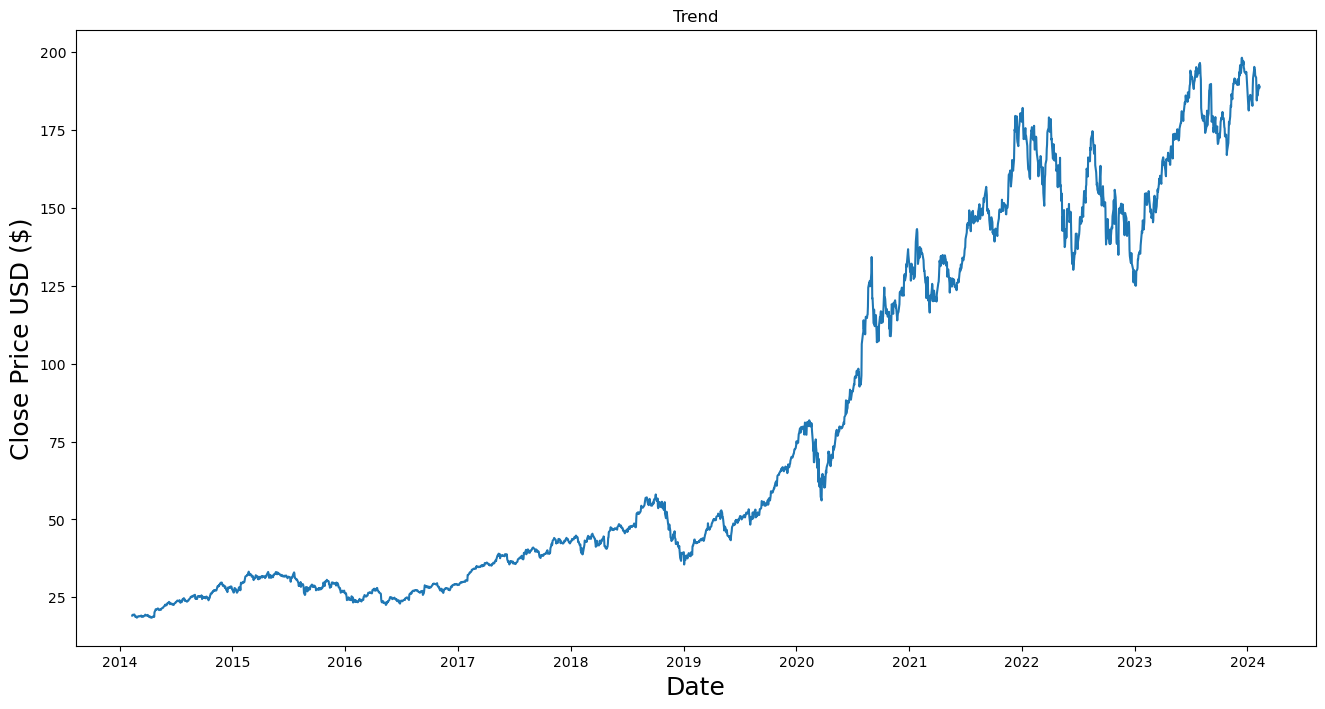

In [8]:
plt.figure(figsize=(16,8))
plt.plot(df['Date'], df['Close'])
plt.title('Trend')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

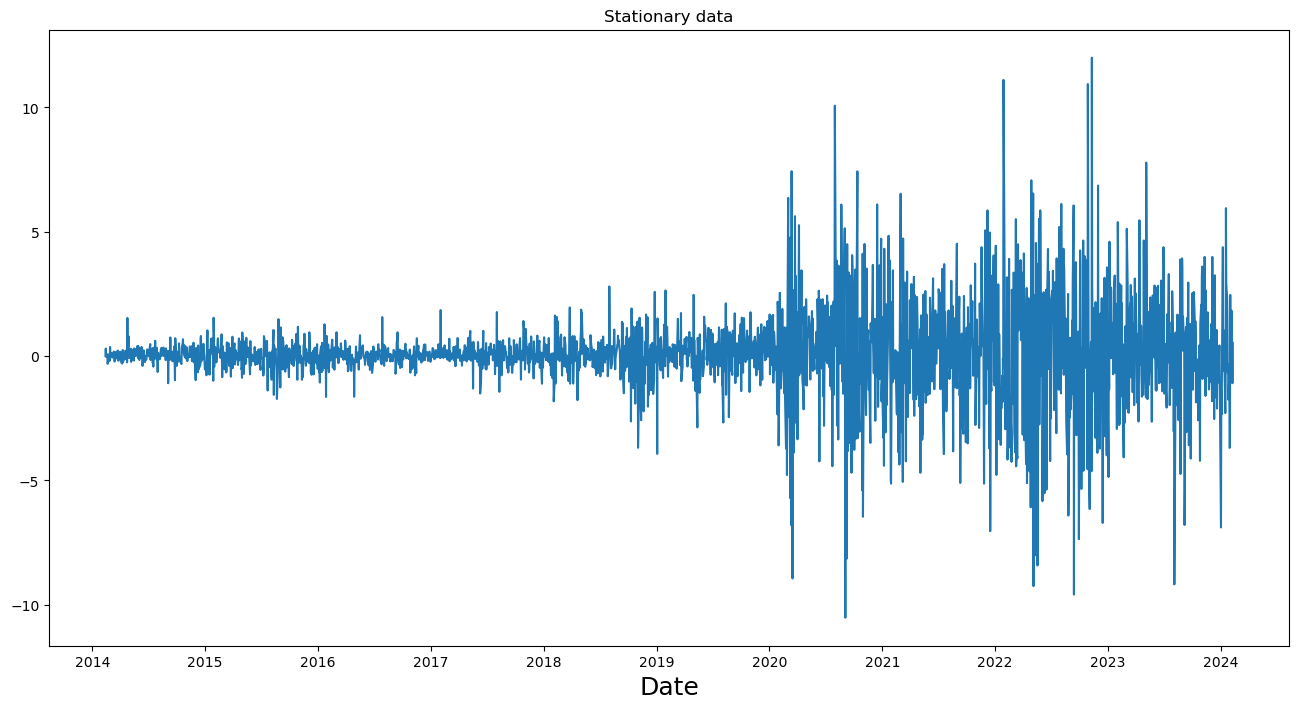

In [9]:
# yt = yt-y(t-1) 
df['Close Shift'] = df['Close'] - df['Close'].shift(1)
y = df['Close Shift']

plt.figure(figsize=(16,8))
plt.plot(df['Date'],df['Close Shift'])
plt.title('Stationary data')
plt.xlabel('Date', fontsize=18)
plt.show()

In [10]:
df.columns

Index(['Date', 'Close', 'Close Shift'], dtype='object')

In [11]:
 # Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df = df.rename(columns = {'Date' : 'ds', 'Close Shift' : 'y'})

  # Sort the DataFrame by `ds` in ascending order
prophet_df = prophet_df.sort_values('ds', ascending = True)

display(prophet_df)

,ds,Close,y
0,2014-02-11,19.141430,NaN
1,2014-02-12,19.139999,-0.001431
2,2014-02-13,19.443930,0.303930
3,2014-02-14,19.428213,-0.015717
4,2014-02-18,19.499643,0.071430
...,...,...,...
2512,2024-02-05,187.679993,1.829987
2513,2024-02-06,189.300003,1.620010
2514,2024-02-07,189.410004,0.110001
2515,2024-02-08,188.320007,-1.089996


In [12]:
## Split the Data
train_data_len = int(0.8*len(df))
train_data_len

2013

In [13]:
#80% for training and 20% for testing
df_train = prophet_df[:train_data_len]
df_test = prophet_df[train_data_len:]
df_train.head(), df_train.shape

(          ds      Close         y
 0 2014-02-11  19.141430       NaN
 1 2014-02-12  19.139999 -0.001431
 2 2014-02-13  19.443930  0.303930
 3 2014-02-14  19.428213 -0.015717
 4 2014-02-18  19.499643  0.071430,
 (2013, 3))

In [14]:
model = Prophet(growth='linear')

# Fit the Prophet model.
model.fit(df_train)

c:\Users\kahbe\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
periods = len(df)-len(df_train)
periods

504

In [16]:
forecast = model.make_future_dataframe(periods= periods)
display(forecast)

,ds
0,2014-02-11
1,2014-02-12
2,2014-02-13
3,2014-02-14
4,2014-02-18
...,...
2512,2023-06-22
2513,2023-06-23
2514,2023-06-24
2515,2023-06-25


In [17]:
# Make Prediction 
prediction = model.predict(forecast)

prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-02-11,-0.008113,-1.873220,1.695678,-0.008113,-0.008113,-0.040206,-0.040206,-0.040206,0.022117,0.022117,0.022117,-0.062323,-0.062323,-0.062323,0.0,0.0,0.0,-0.048318
1,2014-02-12,-0.008067,-1.738064,1.762620,-0.008067,-0.008067,-0.057337,-0.057337,-0.057337,0.021704,0.021704,0.021704,-0.079041,-0.079041,-0.079041,0.0,0.0,0.0,-0.065404
2,2014-02-13,-0.008021,-2.005769,1.592524,-0.008021,-0.008021,-0.195923,-0.195923,-0.195923,-0.100645,-0.100645,-0.100645,-0.095278,-0.095278,-0.095278,0.0,0.0,0.0,-0.203944
3,2014-02-14,-0.007976,-1.819367,1.531398,-0.007976,-0.007976,-0.192578,-0.192578,-0.192578,-0.081741,-0.081741,-0.081741,-0.110837,-0.110837,-0.110837,0.0,0.0,0.0,-0.200554
4,2014-02-18,-0.007793,-1.811225,1.522801,-0.007793,-0.007793,-0.141158,-0.141158,-0.141158,0.022117,0.022117,0.022117,-0.163276,-0.163276,-0.163276,0.0,0.0,0.0,-0.148951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2023-06-22,0.248041,-1.545129,1.909035,0.246209,0.250065,-0.005146,-0.005146,-0.005146,-0.100645,-0.100645,-0.100645,0.095499,0.095499,0.095499,0.0,0.0,0.0,0.242895
2513,2023-06-23,0.248138,-1.557284,1.871563,0.246300,0.250168,0.021331,0.021331,0.021331,-0.081741,-0.081741,-0.081741,0.103072,0.103072,0.103072,0.0,0.0,0.0,0.269469
2514,2023-06-24,0.248235,-1.405715,2.090396,0.246391,0.250271,0.113707,0.113707,0.113707,0.003315,0.003315,0.003315,0.110392,0.110392,0.110392,0.0,0.0,0.0,0.361942
2515,2023-06-25,0.248332,-1.315481,2.191950,0.246483,0.250375,0.120653,0.120653,0.120653,0.003315,0.003315,0.003315,0.117338,0.117338,0.117338,0.0,0.0,0.0,0.368985


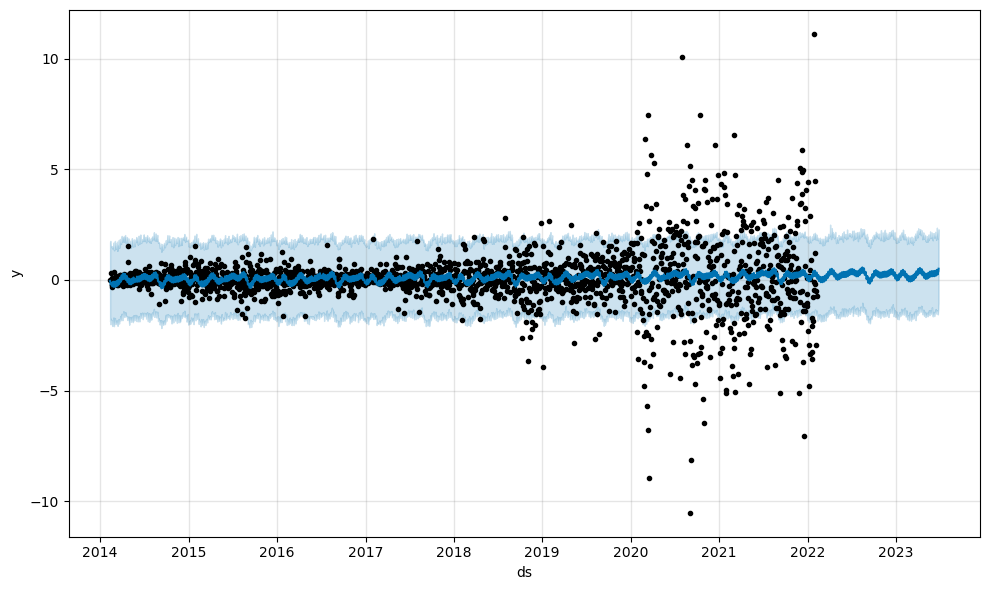

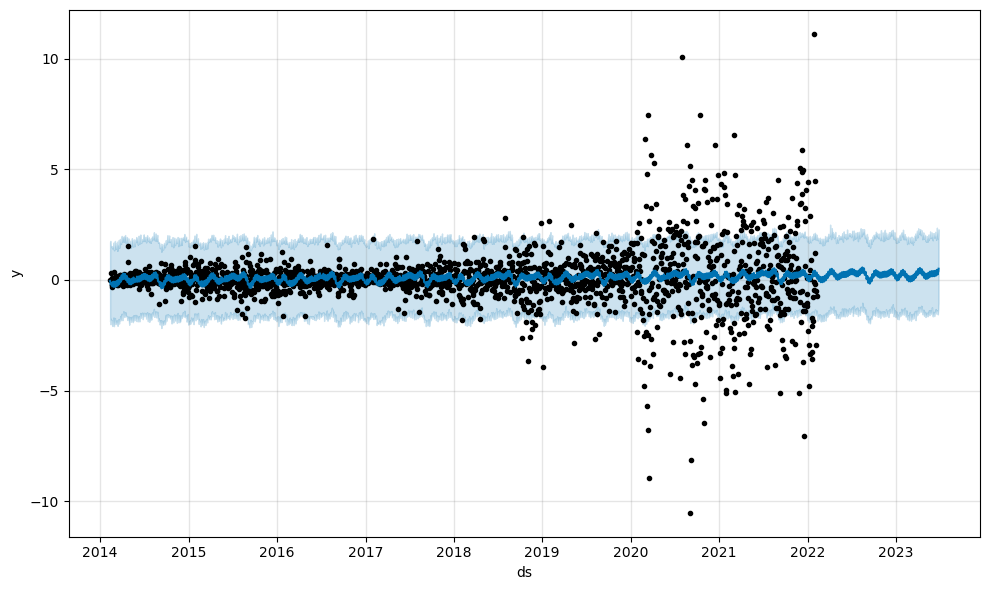

In [18]:

# Plot Our Predictions
model.plot(prediction)

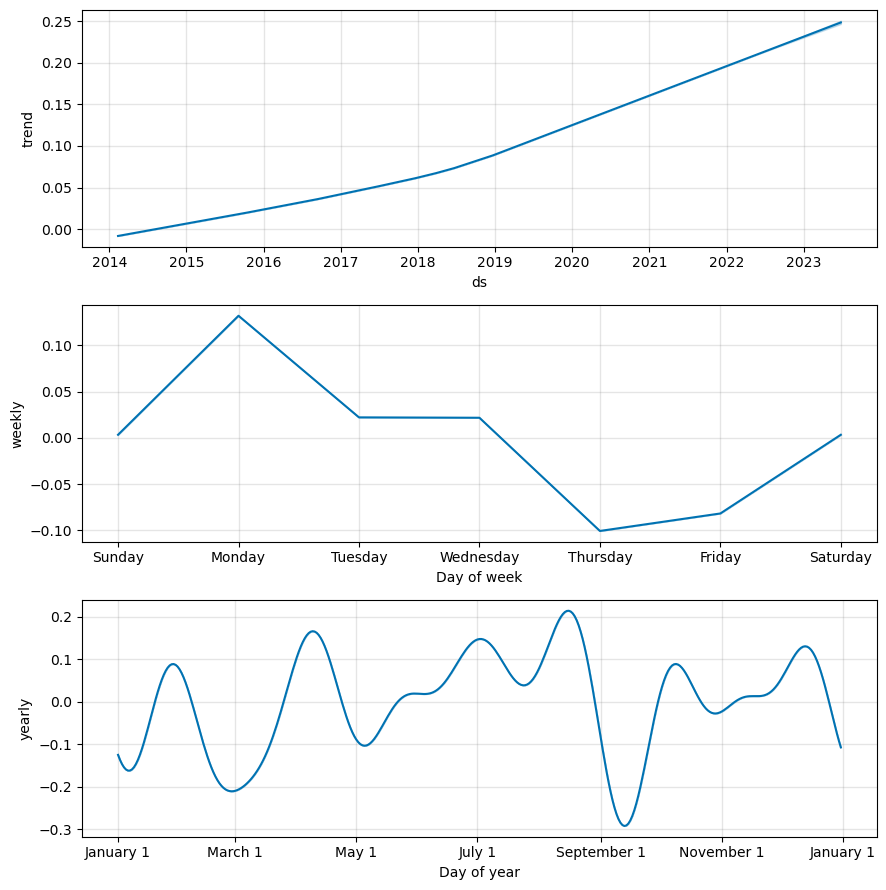

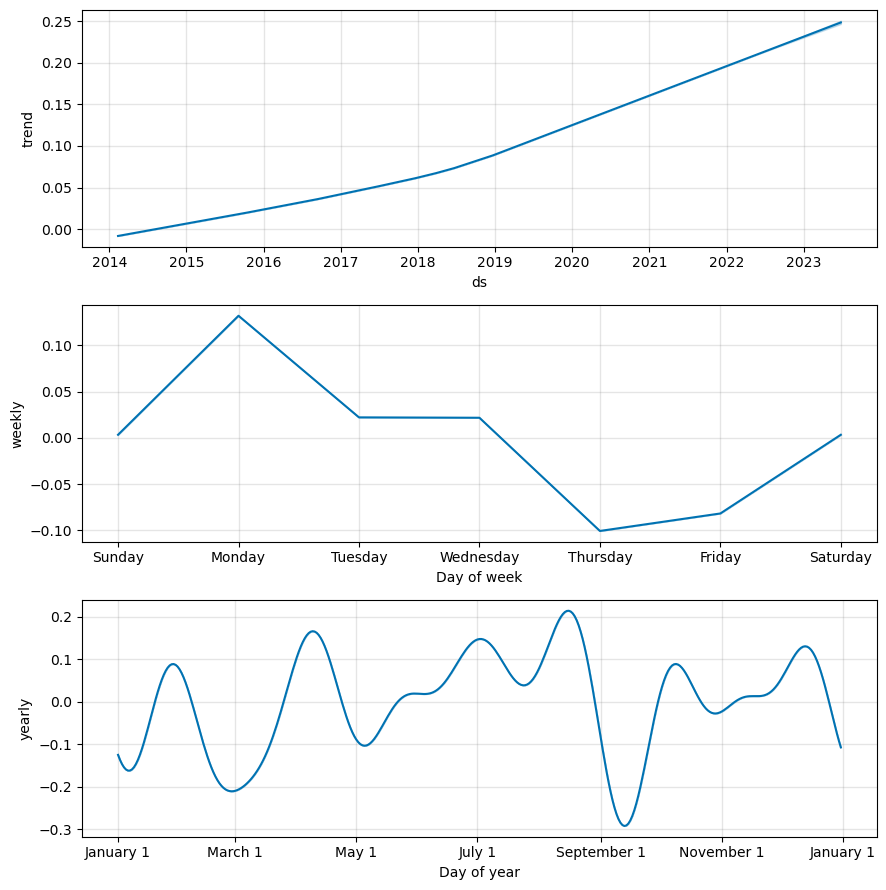

In [19]:

model.plot_components(prediction)

### Cross Validation

In [20]:
## prepare diagnostics report
from prophet.diagnostics import cross_validation
df_train.shape, len(df)-len(df_train)

((2013, 3), 504)

In [21]:
cv = cross_validation(model, initial='2013 days', period='1 days', horizon = '504 days')

  0%|          | 0/401 [00:00<?, ?it/s]

22:44:00 - cmdstanpy - INFO - Chain [1] start processing
22:44:00 - cmdstanpy - INFO - Chain [1] done processing
22:44:01 - cmdstanpy - INFO - Chain [1] start processing
22:44:01 - cmdstanpy - INFO - Chain [1] done processing
22:44:02 - cmdstanpy - INFO - Chain [1] start processing
22:44:02 - cmdstanpy - INFO - Chain [1] done processing
22:44:03 - cmdstanpy - INFO - Chain [1] start processing
22:44:03 - cmdstanpy - INFO - Chain [1] done processing
22:44:03 - cmdstanpy - INFO - Chain [1] start processing
22:44:03 - cmdstanpy - INFO - Chain [1] done processing
22:44:04 - cmdstanpy - INFO - Chain [1] start processing
22:44:04 - cmdstanpy - INFO - Chain [1] done processing
22:44:05 - cmdstanpy - INFO - Chain [1] start processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing
22:44:05 - cmdstanpy - INFO - Chain [1] start processing
22:44:05 - cmdstanpy - INFO - Chain [1] done processing
22:44:06 - cmdstanpy - INFO - Chain [1] start processing
22:44:06 - cmdstanpy - INFO - Chain [1]

In [22]:
display(cv)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-08-19,0.113556,-0.612574,0.893220,0.962502,2019-08-18
1,2019-08-20,0.112535,-0.621889,0.791737,0.002499,2019-08-18
2,2019-08-21,0.141710,-0.546156,0.826542,0.570000,2019-08-18
3,2019-08-22,0.044683,-0.691354,0.723982,-0.044998,2019-08-18
4,2019-08-23,0.033771,-0.743961,0.790245,-2.455002,2019-08-18
...,...,...,...,...,...,...
139384,2022-02-01,0.349054,-0.889850,1.661075,-0.169998,2020-09-21
139385,2022-02-02,0.445117,-0.898388,1.846262,1.229996,2020-09-21
139386,2022-02-03,0.251056,-1.023204,1.608114,-2.940002,2020-09-21
139387,2022-02-04,0.309090,-0.941036,1.601668,-0.509995,2020-09-21


### Performance Metrics

In [23]:
from prophet.diagnostics import performance_metrics
df_train_pm = performance_metrics(cv)

In [24]:
display(df_train_pm)

,horizon,mse,rmse,mae,mdape,smape,coverage
0,51 days,5.242200,2.289585,1.524152,0.996400,1.729464,0.459770
1,52 days,5.262508,2.294016,1.528669,0.996312,1.730842,0.458392
2,53 days,5.282568,2.298384,1.533042,0.996718,1.732177,0.457025
3,54 days,5.302274,2.302667,1.537253,0.996740,1.733380,0.455702
4,55 days,5.321466,2.306830,1.541277,0.997078,1.734473,0.454730
...,...,...,...,...,...,...,...
449,500 days,5.063915,2.250314,1.729374,0.995702,1.706955,0.365254
450,501 days,5.077538,2.253339,1.731426,0.996412,1.708262,0.365005
451,502 days,5.089948,2.256091,1.733346,0.996713,1.709501,0.364816
452,503 days,5.102720,2.258920,1.735309,0.996638,1.710681,0.364112


In [25]:
MSE = sum(df_train_pm['mse'])/len(df_train_pm)
RMSE = sum(df_train_pm['rmse'])/len(df_train_pm)
MSE, RMSE

(6.061272147525116, 2.457219285750792)

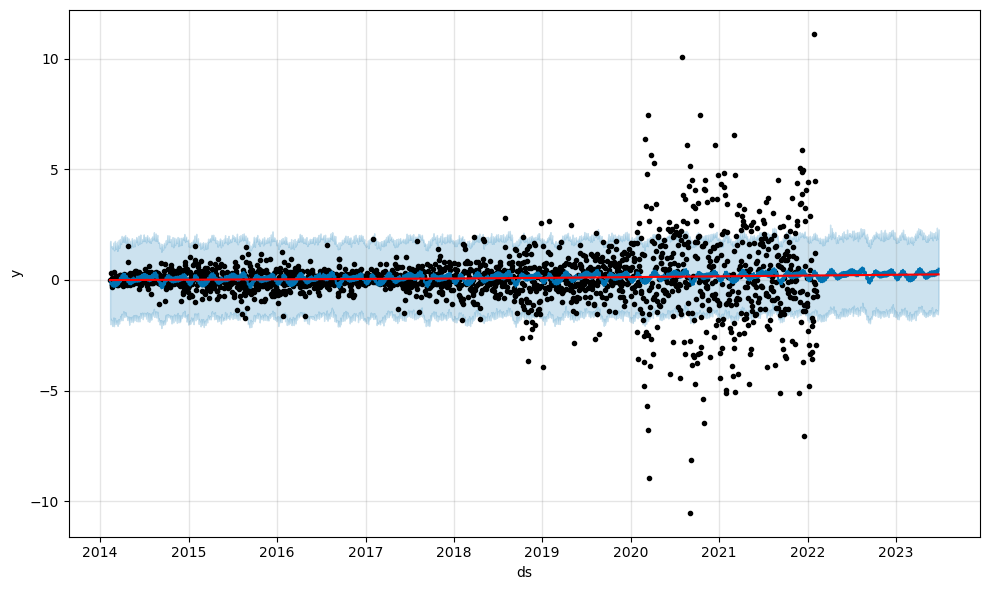

In [26]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(prediction)
a = add_changepoints_to_plot(fig.gca(), model, prediction)
     

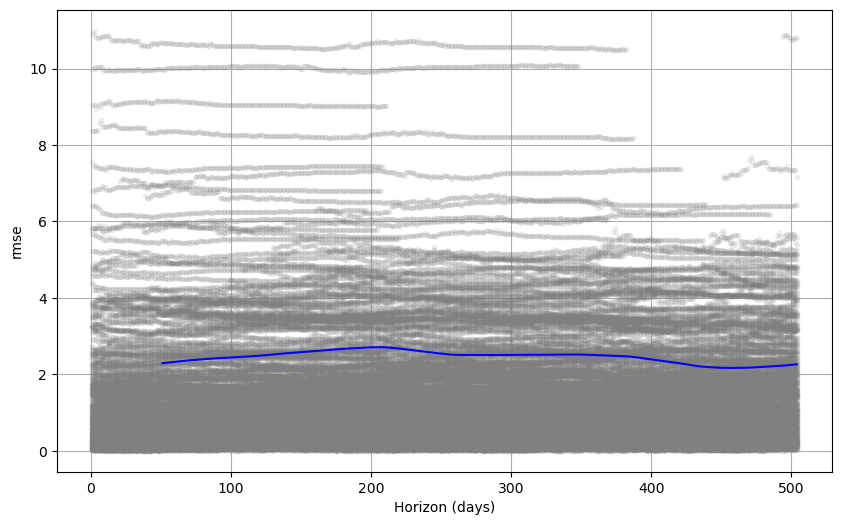

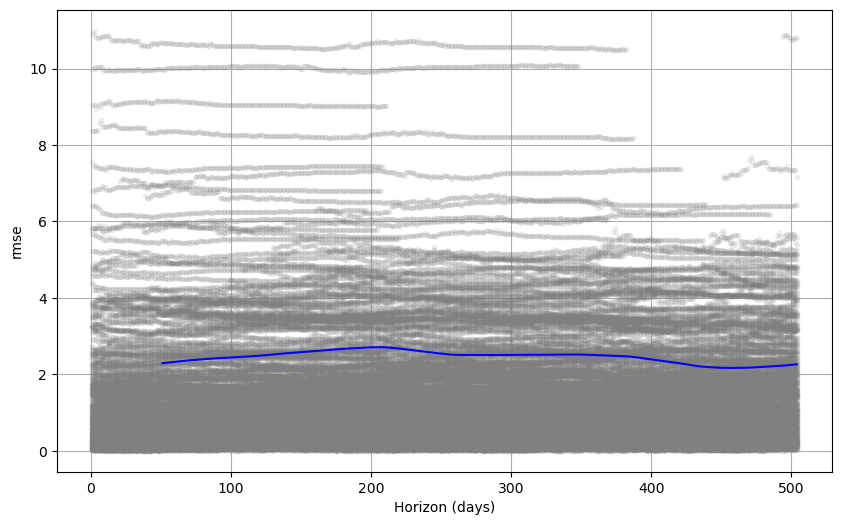

In [27]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv,metric='rmse')

In [47]:
print(prophet_df.columns)


prediction.reset_index(inplace=True)
prediction.rename(columns={'index': 'ds'}, inplace=True)
print("Columns in prediction:", prediction.columns)

Index(['ds', 'Close', 'y'], dtype='object')
Columns in prediction: Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'forecasted_close'],
      dtype='object')


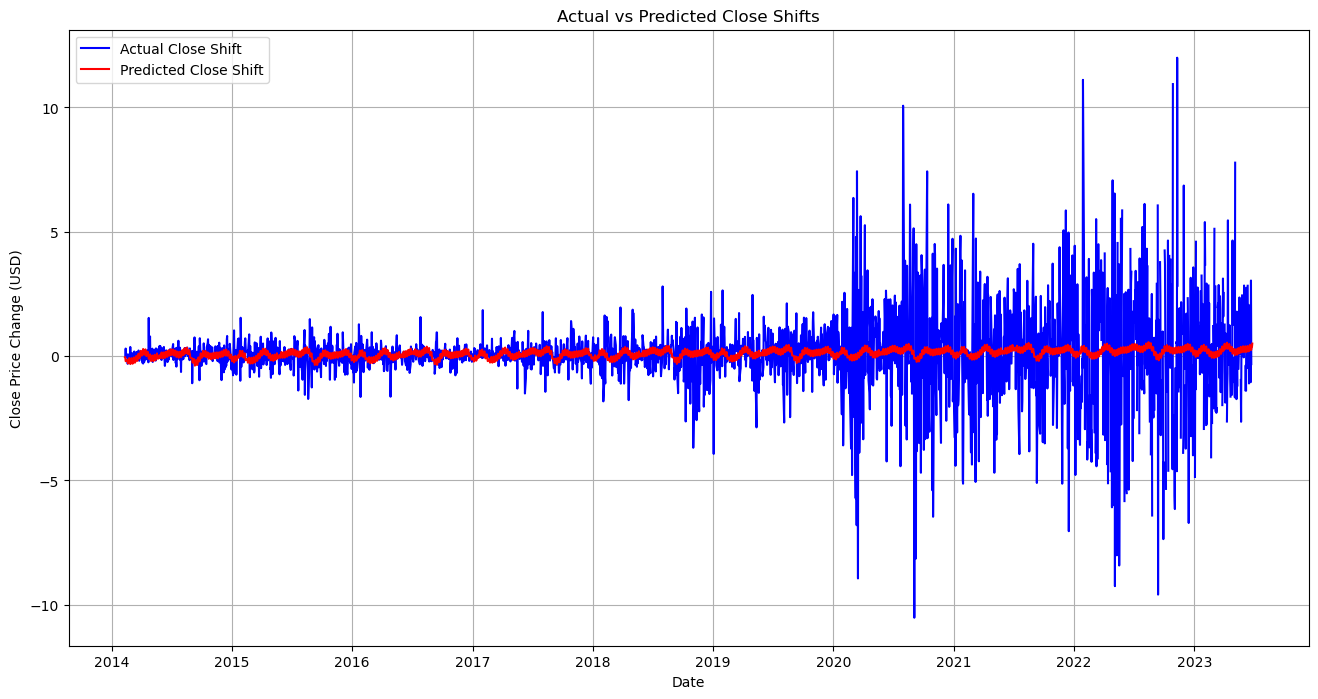

In [49]:
# Merge the actual and predicted data on the 'ds' column
merged_df = prediction[['ds', 'yhat']].merge(prophet_df[['ds', 'y']], on='ds', how='left')

# Plotting
plt.figure(figsize=(16, 8))
plt.plot(merged_df['ds'], merged_df['y'], label='Actual Close Shift', color='blue')
plt.plot(merged_df['ds'], merged_df['yhat'], label='Predicted Close Shift', color='red')
plt.title('Actual vs Predicted Close Shifts')
plt.xlabel('Date')
plt.ylabel('Close Price Change (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Rename the columns
from datetime import timedelta

predictions = prediction.rename(columns={
    'yhat': 'Most Likely Case',
    'yhat_lower': 'Worst Case',
    'yhat_upper': 'Best Case'
})

# Ensure 'ds' column is of datetime type
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Define the start date for filtering
start_date = pd.to_datetime('2022-12-20')

# Determine the last date in the DataFrame and add 30 days for an end date
end_date = forecast['ds'].max() + timedelta(days=30)

# Filter the DataFrame for the date range
filtered_forecast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
# Save to CSV without the index
filtered_forecast.to_csv(os.path.join(forecasts_folder, f"{asset}_forecast.csv"), index=False)

print(f"Forecast CSV for {asset} saved successfully.")

Forecast CSV for AAPL saved successfully.


In [74]:
df.reset_index(inplace=True)
print(df.columns)
print(df)


Index(['Date', 'Close', 'Close Shift'], dtype='object')
           Date       Close  Close Shift
0    2014-02-11   19.141430          NaN
1    2014-02-12   19.139999    -0.001431
2    2014-02-13   19.443930     0.303930
3    2014-02-14   19.428213    -0.015717
4    2014-02-18   19.499643     0.071430
...         ...         ...          ...
2512 2024-02-05  187.679993     1.829987
2513 2024-02-06  189.300003     1.620010
2514 2024-02-07  189.410004     0.110001
2515 2024-02-08  188.320007    -1.089996
2516 2024-02-09  188.850006     0.529999

[2517 rows x 3 columns]
